# Mobile phone data tutorial

In this short tutorial, we will explore how we can work with some mobile phone data to understand the dynamics of our cities.

The data set is publicly available for download at the following links:

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/EGZHFV

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/QJWLFU

There is also a paper that provides details about the data set used here, as well as other publicly available data sets that you may find interesting:

https://www.nature.com/articles/sdata201555



Here some advice and guide to install python:

An easy documentation to install python using Anaconda on MAC OS: https://docs.anaconda.com/free/anaconda/install/mac-os/

Documentation to install python using anaconda on Windows: https://docs.anaconda.com/free/anaconda/install/windows/

Once you open Anaconda, you should be able to find the Jupyter Notebook with an "Install" button that you can click (see below):

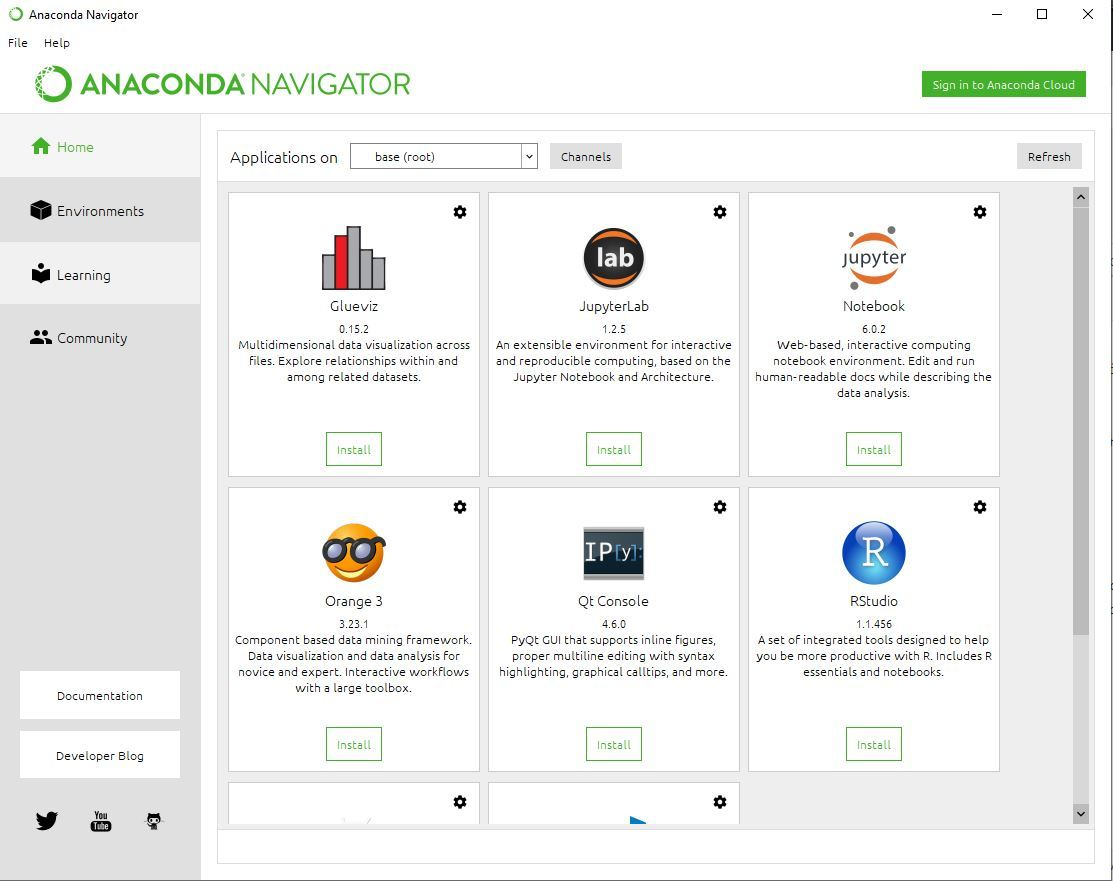

### Import required libraries

In [1]:
import pandas as pd
import geopandas as gpd
import contextily as cx
from datetime import datetime
import os

### Define a function used in this script

In [2]:
def find_cell_id(coords, grid):
    """
    Function to find the cell id within which a point falls.

    Parameters:
    coords (tuple): A tuple containing the (x, y) coordinates of the point.
    grid (geopandas.GeoDataFrame): The GeoDataFrame containing the grid.

    Returns:
    str or None: The ID of the cell containing the point, or None if the point is not within any polygon.
    """
    # Ensure crs of two geodataframes match
    coords.to_crs(crs = grid.crs, inplace = True)
    
    # Perform a spatial join between the point GeoDataFrame and the polygon GeoDataFrame
    temp_gdf = gpd.sjoin(coords, grid, how="left", predicate="within")
    
    # Extract the label of the polygon containing the point, if any
    if not temp_gdf.empty:
        return temp_gdf.iloc[0]['cellId']
    else:
        return None

### Read data files

In [15]:
data_files = ['https://github.com/FedericoBotta/mobility/releases/download/v1/sms-call-internet-mi-2013-11-0' + str(x) + '.txt' for x in range(1, 2)]

# List all files in the subfolder
#files = [os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]

# Define the column names
column_names = ['Square_id', 'Timestamp', 'Country_code', 'SMS-in', 'SMS-out', 'Call-in', 'Call-out', 'Internet']

# Initialize an empty list to store individual DataFrames
dataframes = []

# Loop through each file and read it into a DataFrame with specified column names
for file in data_files:
    # Read the file and specify the column names
    df = pd.read_csv(file, names=column_names, sep = '\t')  
    dataframes.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
mobile_df = pd.concat(dataframes, ignore_index=True)
mobile_df['Timestamp'] = mobile_df['Timestamp'].apply(lambda x: datetime.utcfromtimestamp(x/1000))

# Read the file containing the geographical data
milano_grid = gpd.read_file('https://github.com/FedericoBotta/mobility/releases/download/v1/milano-grid.geojson')
milano_grid.to_crs(epsg=3857, inplace = True)

### Explore the data

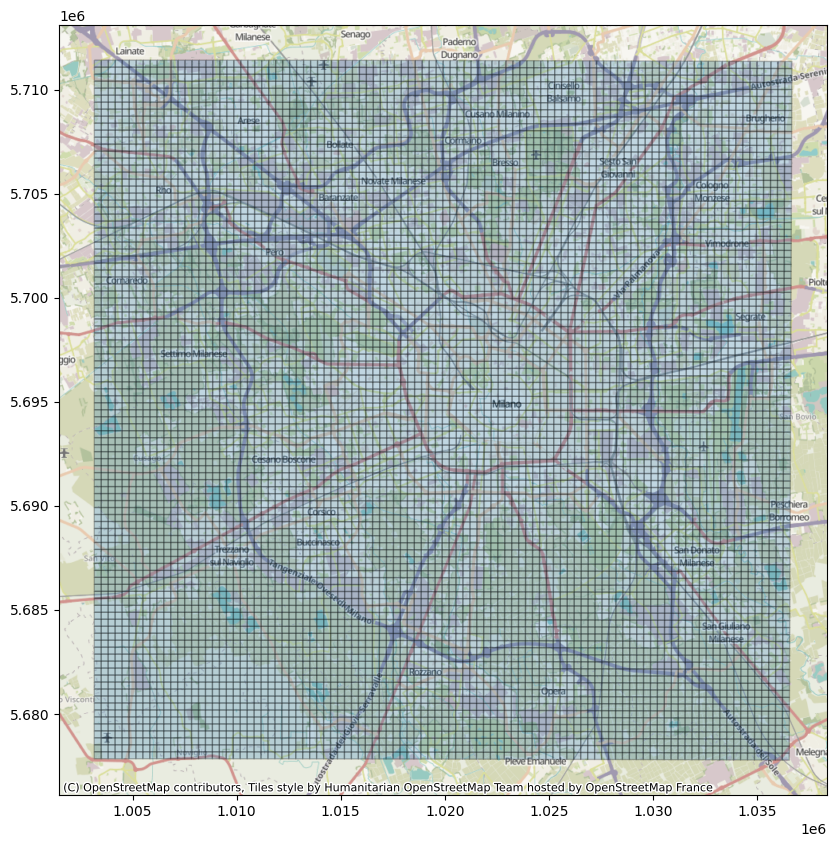

In [11]:
# First let's have a look at a map of the area for which data is available

ax = milano_grid.plot(figsize = (10,10), alpha = 0.25, edgecolor = 'black')
cx.add_basemap(ax)

<Axes: xlabel='Timestamp'>

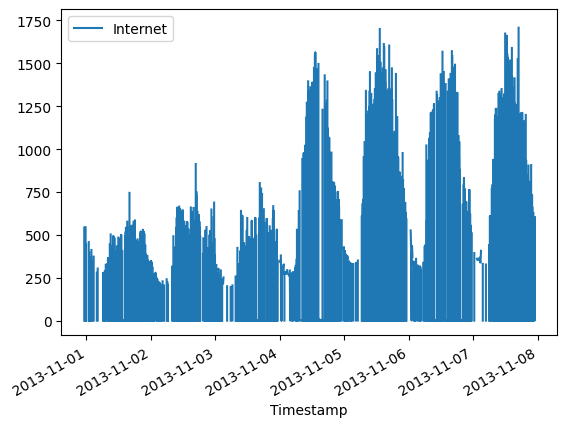

In [12]:
# Then let's plot the time series of the data for an individual cell in the study area

[lat, long] = [45.4683364819956, 9.174417943674701]
point_df = pd.DataFrame({'Long': [long], 'Lat': [lat]})

point_gdf = gpd.GeoDataFrame(point_df, geometry=gpd.points_from_xy(point_df.Long, point_df.Lat, crs="EPSG:4326"))

cell_id = find_cell_id(point_gdf,milano_grid)

cell_df = mobile_df[mobile_df['Square_id'] == cell_id]
cell_df.plot(x = 'Timestamp', y = 'Internet')

<Axes: xlabel='Timestamp'>

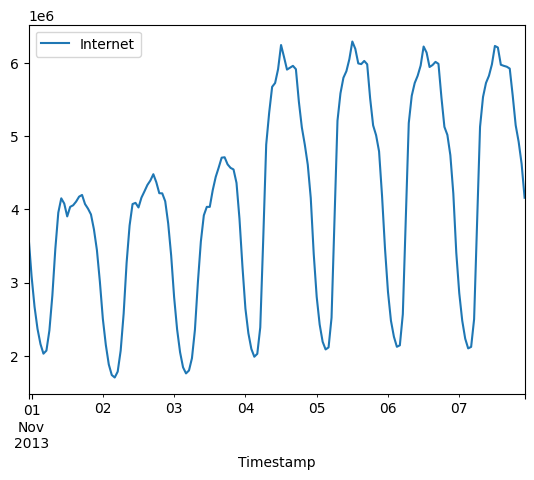

In [13]:
# We can make the data a bit less noisy and make any pattern more obvious by aggregating the original data.
# Here we aggregate it to hourly, but feel free to explore other aggregation levels!

temp_df = mobile_df.set_index('Timestamp')
hourly = temp_df.resample('1h').sum()
hourly.reset_index(inplace = True)
hourly.plot(x = 'Timestamp', y = 'Internet')